In [1]:
import cv2
import numpy as np 
import glob
import os
import os.path
import imutils

from matplotlib import pyplot as plt
%matplotlib inline

# Spliting 


- convert  image to grayscale 
- Extracting letters by making simple vertical cuts at 20%,40%,60% and 80%
- save each character as a single image (no cleanup)
## extracting letters by splitting only (no cleanup)

In [2]:
CAPTCHA_IMAGE_FOLDER = "smaples"
OUTPUT_FOLDER = "extracted_letter"

# Get a list of all the captcha images we need to process
captcha_image_files = glob.glob(os.path.join(CAPTCHA_IMAGE_FOLDER, "*"))
counts = {}

# loop over the image paths
for (i, captcha_image_file) in enumerate(captcha_image_files):
    print("[INFO] processing image {}/{}".format(i + 1, len(captcha_image_files)))

    # Since the filename contains the captcha text (i.e. "2A2X.png" has the text "2A2X"),
    # grab the base filename as the text
    filename = os.path.basename(captcha_image_file)
    captcha_correct_text = os.path.splitext(filename)[0]

    # Load the image and convert it to grayscale
    image = cv2.imread(captcha_image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    first = thresh[0:,27:50]
    second = thresh[0:,49:72]
    third = thresh[0:,69:92]
    forth = thresh[0:,92:115]
    fivth = thresh[0:,115:138]

    images = [first, second, third, forth, fivth]
    

    for letter_bounding_box, letter_text in zip(images, captcha_correct_text):

        # Get the folder to save the image in
        save_path = os.path.join(OUTPUT_FOLDER, letter_text)

        # if the output directory does not exist, create it
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # write the letter image to a file
        count = counts.get(letter_text, 1)
        p = os.path.join(save_path, "{}.jpg".format(str(count).zfill(6)))
        cv2.imwrite(p, letter_bounding_box)

        # increment the count for the current key
        counts[letter_text] = count + 1

[INFO] processing image 1/214
[INFO] processing image 2/214
[INFO] processing image 3/214
[INFO] processing image 4/214
[INFO] processing image 5/214
[INFO] processing image 6/214
[INFO] processing image 7/214
[INFO] processing image 8/214
[INFO] processing image 9/214
[INFO] processing image 10/214
[INFO] processing image 11/214
[INFO] processing image 12/214
[INFO] processing image 13/214
[INFO] processing image 14/214
[INFO] processing image 15/214
[INFO] processing image 16/214
[INFO] processing image 17/214
[INFO] processing image 18/214
[INFO] processing image 19/214
[INFO] processing image 20/214
[INFO] processing image 21/214
[INFO] processing image 22/214
[INFO] processing image 23/214
[INFO] processing image 24/214
[INFO] processing image 25/214
[INFO] processing image 26/214
[INFO] processing image 27/214
[INFO] processing image 28/214
[INFO] processing image 29/214
[INFO] processing image 30/214
[INFO] processing image 31/214
[INFO] processing image 32/214
[INFO] processing

# Training Part


In [2]:
import pandas as pd
import pickle
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
from sklearn.decomposition import PCA

Using TensorFlow backend.


In [4]:
LETTER_IMAGES_FOLDER = 'extracted_letter'

In [5]:
img =[]
labels = []
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    image = cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)
        
    # Adding a third channel dimension
    image = np.expand_dims(image, axis=2)
    
    # Grabbing the name of the letter 
    label = image_file.split(os.path.sep)[-2]
    
    # appending
    img.append(image)
    labels.append(label)

In [6]:
X = np.array(img)
y = np.array(labels)

#scale the raw pixel intensities to the range [0, 1] to improve training
X = np.array(X, dtype="float") / 255.0
y = np.array(y)

In [7]:
# splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

# encoding categorical data (get dummy variables)
lb = LabelBinarizer().fit(y_train)
y_train = lb.transform(y_train)
y_test = lb.transform(y_test)

In [ ]:
# Save the mapping from labels to one-hot encodings.
# We'll need it later when we use the model to decode what it's predictions mean
with open('model_labels_v1.dat', "wb") as f:
    pickle.dump(lb, f)

## CNN 

In [17]:
cnn_model = Sequential()

# 2 converatail layers
cnn_model.add(Conv2D(20, (5, 5), padding="same", activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# flatt layer
cnn_model.add(Flatten())

#fully connected layer
cnn_model.add(Dense(500, activation="relu"))


#output layer
cnn_model.add(Dense(19, activation="softmax"))

cnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [18]:
#Fitting 
cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=30, verbose=1)

Train on 749 samples, validate on 321 samples
Epoch 1/30
749/749 [==============================] - 3s 3ms/step - loss: 2.4742 - accuracy: 0.2737 - val_loss: 1.4395 - val_accuracy: 0.5857
Epoch 2/30
749/749 [==============================] - 2s 3ms/step - loss: 1.1195 - accuracy: 0.6862 - val_loss: 1.0781 - val_accuracy: 0.7103
Epoch 3/30
749/749 [==============================] - 3s 3ms/step - loss: 0.6933 - accuracy: 0.7891 - val_loss: 0.9763 - val_accuracy: 0.7445
Epoch 4/30
749/749 [==============================] - 2s 3ms/step - loss: 0.4313 - accuracy: 0.8705 - val_loss: 0.8166 - val_accuracy: 0.7944
Epoch 5/30
749/749 [==============================] - 2s 3ms/step - loss: 0.2815 - accuracy: 0.9199 - val_loss: 0.7859 - val_accuracy: 0.7913
Epoch 6/30
749/749 [==============================] - 2s 3ms/step - loss: 0.2114 - accuracy: 0.9466 - val_loss: 0.8339 - val_accuracy: 0.7882
Epoch 7/30
749/749 [==============================] - 2s 3ms/step - loss: 0.1829 - accuracy: 0.9439 - 

In [19]:
score = cnn_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.2710712661141983
Test accuracy: 0.8130841255187988


In [20]:
# Hyperparameters Optimization
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import  RandomizedSearchCV

def create_model():
    # create model
    c_model = Sequential()

    c_model.add(Conv2D(20, (5, 5), padding="same", activation="relu"))
    c_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    c_model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
    c_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # flatt layer
    c_model.add(Flatten())

    #fully connected layer
    c_model.add(Dense(500, activation="relu"))


    #output layer
    c_model.add(Dense(19, activation="softmax"))

    c_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return c_model




model = KerasClassifier(build_fn=create_model)




# Specify parameters and distributions to sample from
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_dist = dict(batch_size=batch_size, epochs=epochs)



# Search in action!
n_iter_search = 16 # Number of parameter settings that are sampled.
random_search = RandomizedSearchCV(estimator=model, 
                                    param_distributions=param_dist,
                                    n_iter=n_iter_search)


random_search.fit(X_train, y_train)

# Show the results
print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))


/Users/bodor/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/10
499/499 [==============================] - 1s 3ms/step - loss: 2.8303 - accuracy: 0.1784
Epoch 2/10
499/499 [==============================] - 1s 2ms/step - loss: 1.9095 - accuracy: 0.5130
Epoch 3/10
499/499 [==============================] - 1s 3ms/step - loss: 1.1653 - accuracy: 0.6613
Epoch 4/10
499/499 [==============================] - 1s 3ms/step - loss: 0.8128 - accuracy: 0.7615
Epoch 5/10
499/499 [==============================] - 1s 3ms/step - loss: 0.6484 - accuracy: 0.8056
Epoch 6/10
499/499 [==============================] - 1s 3ms/step - loss: 0.4924 - accuracy: 0.8597
Epoch 7/10
499/499 [==============================] - 1s 3ms/step - loss: 0.3822 - accuracy: 0.8838
Epoch 8/10
499/499 [==============================] - 1s 3ms/step - loss: 0.2860 - accuracy: 0.9198
Epoch 9/10
499/499 [==============================] - 2s 3ms/step - loss: 0.1871 - accuracy: 0.9539
Epoch 10/10
250/250 [==============================] - 0s 787us/step
Epoch 1/10
499/499 [===========

499/499 [==============================] - 1s 2ms/step - loss: 0.0102 - accuracy: 1.0000
Epoch 29/100
499/499 [==============================] - 1s 2ms/step - loss: 0.0087 - accuracy: 1.0000
Epoch 30/100
499/499 [==============================] - 1s 2ms/step - loss: 0.0067 - accuracy: 1.0000
Epoch 31/100
499/499 [==============================] - 1s 2ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 32/100
499/499 [==============================] - 1s 2ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 33/100
499/499 [==============================] - 1s 2ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 34/100
499/499 [==============================] - 1s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 35/100
499/499 [==============================] - 1s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 36/100
499/499 [==============================] - 1s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 37/100
499/499 [==============================] - 1s 2ms/step - loss: 0.0019 - accuracy: 

500/500 [==============================] - 1s 2ms/step - loss: 0.6494 - accuracy: 0.8260
Epoch 7/100
500/500 [==============================] - 1s 2ms/step - loss: 0.5260 - accuracy: 0.8560
Epoch 8/100
500/500 [==============================] - 1s 2ms/step - loss: 0.4037 - accuracy: 0.8960
Epoch 9/100
500/500 [==============================] - 1s 2ms/step - loss: 0.3136 - accuracy: 0.9200
Epoch 10/100
500/500 [==============================] - 1s 2ms/step - loss: 0.2346 - accuracy: 0.9500
Epoch 11/100
500/500 [==============================] - 1s 2ms/step - loss: 0.1890 - accuracy: 0.9500
Epoch 12/100
500/500 [==============================] - 1s 2ms/step - loss: 0.1439 - accuracy: 0.9760
Epoch 13/100
500/500 [==============================] - 1s 2ms/step - loss: 0.1052 - accuracy: 0.9900
Epoch 14/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0828 - accuracy: 0.9920
Epoch 15/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0744 - accuracy: 0.9

499/499 [==============================] - 2s 5ms/step - loss: 2.2334 - accuracy: 0.3427
Epoch 2/100
499/499 [==============================] - 2s 4ms/step - loss: 0.8943 - accuracy: 0.7515
Epoch 3/100
499/499 [==============================] - 2s 4ms/step - loss: 0.5072 - accuracy: 0.8457
Epoch 4/100
499/499 [==============================] - 2s 4ms/step - loss: 0.2719 - accuracy: 0.9238
Epoch 5/100
499/499 [==============================] - 2s 4ms/step - loss: 0.1732 - accuracy: 0.9459
Epoch 6/100
499/499 [==============================] - 2s 4ms/step - loss: 0.1651 - accuracy: 0.9399
Epoch 7/100
499/499 [==============================] - 2s 4ms/step - loss: 0.0630 - accuracy: 0.9840
Epoch 8/100
499/499 [==============================] - 2s 4ms/step - loss: 0.0577 - accuracy: 0.9840
Epoch 9/100
499/499 [==============================] - 2s 4ms/step - loss: 0.0241 - accuracy: 0.9940
Epoch 10/100
499/499 [==============================] - 2s 4ms/step - loss: 0.0532 - accuracy: 0.9800
E

499/499 [==============================] - 2s 4ms/step - loss: 1.2595e-05 - accuracy: 1.0000
Epoch 80/100
499/499 [==============================] - 2s 4ms/step - loss: 1.2217e-05 - accuracy: 1.0000
Epoch 81/100
499/499 [==============================] - 2s 4ms/step - loss: 1.1712e-05 - accuracy: 1.0000
Epoch 82/100
499/499 [==============================] - 2s 4ms/step - loss: 1.1753e-05 - accuracy: 1.0000
Epoch 83/100
499/499 [==============================] - 2s 4ms/step - loss: 1.0857e-05 - accuracy: 1.0000
Epoch 84/100
499/499 [==============================] - 2s 4ms/step - loss: 1.0452e-05 - accuracy: 1.0000
Epoch 85/100
499/499 [==============================] - 2s 4ms/step - loss: 1.0452e-05 - accuracy: 1.0000
Epoch 86/100
499/499 [==============================] - 2s 4ms/step - loss: 9.8847e-06 - accuracy: 1.0000
Epoch 87/100
499/499 [==============================] - 7197s 14s/step - loss: 9.4232e-06 - accuracy: 1.0000
Epoch 88/100
499/499 [==============================] - 

500/500 [==============================] - 2s 4ms/step - loss: 1.0594e-04 - accuracy: 1.0000
Epoch 34/100
500/500 [==============================] - 2s 5ms/step - loss: 9.9273e-05 - accuracy: 1.0000
Epoch 35/100
500/500 [==============================] - 2s 4ms/step - loss: 9.4611e-05 - accuracy: 1.0000
Epoch 36/100
500/500 [==============================] - 2s 4ms/step - loss: 8.4076e-05 - accuracy: 1.0000
Epoch 37/100
500/500 [==============================] - 2s 4ms/step - loss: 8.0097e-05 - accuracy: 1.0000
Epoch 38/100
500/500 [==============================] - 2s 4ms/step - loss: 7.6422e-05 - accuracy: 1.0000
Epoch 39/100
500/500 [==============================] - 2s 4ms/step - loss: 7.1594e-05 - accuracy: 1.0000
Epoch 40/100
500/500 [==============================] - 2s 4ms/step - loss: 6.4986e-05 - accuracy: 1.0000
Epoch 41/100
500/500 [==============================] - 2s 4ms/step - loss: 6.1702e-05 - accuracy: 1.0000
Epoch 42/100
500/500 [==============================] - 2s 

499/499 [==============================] - 1s 3ms/step - loss: 3.3826e-04 - accuracy: 1.0000
Epoch 40/50
499/499 [==============================] - 1s 2ms/step - loss: 3.1893e-04 - accuracy: 1.0000
Epoch 41/50
499/499 [==============================] - 1s 2ms/step - loss: 3.0119e-04 - accuracy: 1.0000
Epoch 42/50
499/499 [==============================] - 1s 3ms/step - loss: 2.8699e-04 - accuracy: 1.0000
Epoch 43/50
499/499 [==============================] - 1s 3ms/step - loss: 2.7348e-04 - accuracy: 1.0000
Epoch 44/50
499/499 [==============================] - 1s 2ms/step - loss: 2.6131e-04 - accuracy: 1.0000
Epoch 45/50
499/499 [==============================] - 1s 2ms/step - loss: 2.4916e-04 - accuracy: 1.0000
Epoch 46/50
499/499 [==============================] - 1s 3ms/step - loss: 2.3818e-04 - accuracy: 1.0000
Epoch 47/50
499/499 [==============================] - 1s 2ms/step - loss: 2.2856e-04 - accuracy: 1.0000
Epoch 48/50
499/499 [==============================] - 1s 2ms/step 

499/499 [==============================] - 1s 2ms/step - loss: 9.4534e-05 - accuracy: 1.0000
Epoch 96/100
499/499 [==============================] - 1s 2ms/step - loss: 9.2549e-05 - accuracy: 1.0000
Epoch 97/100
499/499 [==============================] - 1s 2ms/step - loss: 9.0213e-05 - accuracy: 1.0000
Epoch 98/100
499/499 [==============================] - 1s 2ms/step - loss: 8.8566e-05 - accuracy: 1.0000
Epoch 99/100
499/499 [==============================] - 1s 2ms/step - loss: 8.6563e-05 - accuracy: 1.0000
Epoch 100/100
250/250 [==============================] - 0s 809us/step
Epoch 1/100
499/499 [==============================] - 1s 3ms/step - loss: 2.8596 - accuracy: 0.1343
Epoch 2/100
499/499 [==============================] - 1s 2ms/step - loss: 2.0339 - accuracy: 0.4669
Epoch 3/100
499/499 [==============================] - 1s 2ms/step - loss: 1.2556 - accuracy: 0.6333
Epoch 4/100
499/499 [==============================] - 1s 2ms/step - loss: 1.0168 - accuracy: 0.7014
Epoch 5/

500/500 [==============================] - 1s 2ms/step - loss: 5.3225e-04 - accuracy: 1.0000
Epoch 52/100
500/500 [==============================] - 1s 2ms/step - loss: 5.2684e-04 - accuracy: 1.0000
Epoch 53/100
500/500 [==============================] - 1s 3ms/step - loss: 4.9629e-04 - accuracy: 1.0000
Epoch 54/100
500/500 [==============================] - 1s 2ms/step - loss: 5.0260e-04 - accuracy: 1.0000
Epoch 55/100
500/500 [==============================] - 1s 2ms/step - loss: 4.6291e-04 - accuracy: 1.0000
Epoch 56/100
500/500 [==============================] - 1s 2ms/step - loss: 4.4062e-04 - accuracy: 1.0000
Epoch 57/100
500/500 [==============================] - 1s 2ms/step - loss: 4.2529e-04 - accuracy: 1.0000
Epoch 58/100
500/500 [==============================] - 1s 2ms/step - loss: 4.1192e-04 - accuracy: 1.0000
Epoch 59/100
500/500 [==============================] - 1s 2ms/step - loss: 3.9772e-04 - accuracy: 1.0000
Epoch 60/100
500/500 [==============================] - 1s 

499/499 [==============================] - 2s 3ms/step - loss: 2.7820e-04 - accuracy: 1.0000
Epoch 30/50
499/499 [==============================] - 2s 3ms/step - loss: 2.5420e-04 - accuracy: 1.0000
Epoch 31/50
499/499 [==============================] - 2s 3ms/step - loss: 2.3345e-04 - accuracy: 1.0000
Epoch 32/50
499/499 [==============================] - 2s 3ms/step - loss: 2.1618e-04 - accuracy: 1.0000
Epoch 33/50
499/499 [==============================] - 2s 3ms/step - loss: 2.0036e-04 - accuracy: 1.0000
Epoch 34/50
499/499 [==============================] - 2s 3ms/step - loss: 1.8672e-04 - accuracy: 1.0000
Epoch 35/50
499/499 [==============================] - 2s 3ms/step - loss: 1.7374e-04 - accuracy: 1.0000
Epoch 36/50
499/499 [==============================] - 2s 3ms/step - loss: 1.6396e-04 - accuracy: 1.0000
Epoch 37/50
499/499 [==============================] - 2s 3ms/step - loss: 1.5420e-04 - accuracy: 1.0000
Epoch 38/50
499/499 [==============================] - 2s 3ms/step 

499/499 [==============================] - 2s 3ms/step - loss: 2.6347e-04 - accuracy: 1.0000
Epoch 36/100
499/499 [==============================] - 2s 3ms/step - loss: 2.5764e-04 - accuracy: 1.0000
Epoch 37/100
499/499 [==============================] - 2s 3ms/step - loss: 2.4320e-04 - accuracy: 1.0000
Epoch 38/100
499/499 [==============================] - 2s 3ms/step - loss: 2.2543e-04 - accuracy: 1.0000
Epoch 39/100
499/499 [==============================] - 2s 3ms/step - loss: 2.1291e-04 - accuracy: 1.0000
Epoch 40/100
499/499 [==============================] - 2s 3ms/step - loss: 2.0286e-04 - accuracy: 1.0000
Epoch 41/100
499/499 [==============================] - 2s 3ms/step - loss: 1.9139e-04 - accuracy: 1.0000
Epoch 42/100
499/499 [==============================] - 2s 3ms/step - loss: 1.8346e-04 - accuracy: 1.0000
Epoch 43/100
499/499 [==============================] - 2s 3ms/step - loss: 1.7580e-04 - accuracy: 1.0000
Epoch 44/100
499/499 [==============================] - 2s 

499/499 [==============================] - 2s 3ms/step - loss: 2.9458e-05 - accuracy: 1.0000
Epoch 90/100
499/499 [==============================] - 2s 3ms/step - loss: 2.8799e-05 - accuracy: 1.0000
Epoch 91/100
499/499 [==============================] - 2s 3ms/step - loss: 2.8008e-05 - accuracy: 1.0000
Epoch 92/100
499/499 [==============================] - 2s 3ms/step - loss: 2.7352e-05 - accuracy: 1.0000
Epoch 93/100
499/499 [==============================] - 2s 3ms/step - loss: 2.6654e-05 - accuracy: 1.0000
Epoch 94/100
499/499 [==============================] - 68s 136ms/step - loss: 2.6053e-05 - accuracy: 1.0000
Epoch 95/100
499/499 [==============================] - 2s 3ms/step - loss: 2.5331e-05 - accuracy: 1.0000
Epoch 96/100
499/499 [==============================] - 2s 4ms/step - loss: 2.4921e-05 - accuracy: 1.0000
Epoch 97/100
499/499 [==============================] - 2s 4ms/step - loss: 2.4120e-05 - accuracy: 1.0000
Epoch 98/100
499/499 [==============================] - 

499/499 [==============================] - 1s 3ms/step - loss: 0.0285 - accuracy: 0.9920
Epoch 14/100
499/499 [==============================] - 1s 3ms/step - loss: 0.0648 - accuracy: 0.9800
Epoch 15/100
499/499 [==============================] - 1s 3ms/step - loss: 0.0253 - accuracy: 0.9940
Epoch 16/100
499/499 [==============================] - 1s 3ms/step - loss: 0.0110 - accuracy: 1.0000
Epoch 17/100
499/499 [==============================] - 1s 3ms/step - loss: 0.0073 - accuracy: 0.9980
Epoch 18/100
499/499 [==============================] - 1s 3ms/step - loss: 0.0126 - accuracy: 0.9960
Epoch 19/100
499/499 [==============================] - 1s 3ms/step - loss: 0.0463 - accuracy: 0.9800
Epoch 20/100
499/499 [==============================] - 1s 3ms/step - loss: 0.0260 - accuracy: 0.9920
Epoch 21/100
499/499 [==============================] - 1s 3ms/step - loss: 0.0217 - accuracy: 0.9920
Epoch 22/100
499/499 [==============================] - 1s 3ms/step - loss: 0.0073 - accuracy: 

Epoch 91/100
499/499 [==============================] - 1s 3ms/step - loss: 6.8435e-05 - accuracy: 1.0000
Epoch 92/100
499/499 [==============================] - 1s 3ms/step - loss: 6.6495e-05 - accuracy: 1.0000
Epoch 93/100
499/499 [==============================] - 1s 3ms/step - loss: 6.5140e-05 - accuracy: 1.0000
Epoch 94/100
499/499 [==============================] - 1s 3ms/step - loss: 6.3686e-05 - accuracy: 1.0000
Epoch 95/100
499/499 [==============================] - 1s 3ms/step - loss: 6.1951e-05 - accuracy: 1.0000
Epoch 96/100
499/499 [==============================] - 1s 3ms/step - loss: 6.0436e-05 - accuracy: 1.0000
Epoch 97/100
499/499 [==============================] - 1s 3ms/step - loss: 5.9247e-05 - accuracy: 1.0000
Epoch 98/100
499/499 [==============================] - 1s 3ms/step - loss: 5.8005e-05 - accuracy: 1.0000
Epoch 99/100
499/499 [==============================] - 1s 3ms/step - loss: 5.6795e-05 - accuracy: 1.0000
Epoch 100/100
250/250 [=======================

500/500 [==============================] - 1s 3ms/step - loss: 4.1873e-04 - accuracy: 1.0000
Epoch 47/100
500/500 [==============================] - 1s 3ms/step - loss: 3.9833e-04 - accuracy: 1.0000
Epoch 48/100
500/500 [==============================] - 1s 3ms/step - loss: 3.8971e-04 - accuracy: 1.0000
Epoch 49/100
500/500 [==============================] - 1s 3ms/step - loss: 3.7316e-04 - accuracy: 1.0000
Epoch 50/100
500/500 [==============================] - 1s 3ms/step - loss: 3.5845e-04 - accuracy: 1.0000
Epoch 51/100
500/500 [==============================] - 1s 3ms/step - loss: 3.4676e-04 - accuracy: 1.0000
Epoch 52/100
500/500 [==============================] - 1s 3ms/step - loss: 3.3553e-04 - accuracy: 1.0000
Epoch 53/100
500/500 [==============================] - 1s 3ms/step - loss: 3.2319e-04 - accuracy: 1.0000
Epoch 54/100
500/500 [==============================] - 1s 3ms/step - loss: 3.1095e-04 - accuracy: 1.0000
Epoch 55/100
500/500 [==============================] - 1s 

499/499 [==============================] - 1s 2ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 25/50
499/499 [==============================] - 1s 2ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 26/50
499/499 [==============================] - 1s 2ms/step - loss: 0.0047 - accuracy: 1.0000
Epoch 27/50
499/499 [==============================] - 1s 2ms/step - loss: 0.0047 - accuracy: 1.0000
Epoch 28/50
499/499 [==============================] - 1s 2ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 29/50
499/499 [==============================] - 1s 2ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 30/50
499/499 [==============================] - 1s 2ms/step - loss: 0.0065 - accuracy: 0.9980
Epoch 31/50
499/499 [==============================] - 1s 2ms/step - loss: 0.0110 - accuracy: 0.9940
Epoch 32/50
499/499 [==============================] - 1s 2ms/step - loss: 0.0103 - accuracy: 0.9960
Epoch 33/50
499/499 [==============================] - 1s 2ms/step - loss: 0.0490 - accuracy: 0.9780
Ep

Epoch 4/50
500/500 [==============================] - 1s 2ms/step - loss: 0.9529 - accuracy: 0.7380
Epoch 5/50
500/500 [==============================] - 1s 2ms/step - loss: 0.7218 - accuracy: 0.8100
Epoch 6/50
500/500 [==============================] - 1s 2ms/step - loss: 0.5656 - accuracy: 0.8380
Epoch 7/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4885 - accuracy: 0.8540
Epoch 8/50
500/500 [==============================] - 1s 2ms/step - loss: 0.3746 - accuracy: 0.8960
Epoch 9/50
500/500 [==============================] - 1s 2ms/step - loss: 0.3235 - accuracy: 0.9100
Epoch 10/50
500/500 [==============================] - 1s 2ms/step - loss: 0.2353 - accuracy: 0.9460
Epoch 11/50
500/500 [==============================] - 1s 2ms/step - loss: 0.1763 - accuracy: 0.9620
Epoch 12/50
500/500 [==============================] - 1s 2ms/step - loss: 0.1134 - accuracy: 0.9740
Epoch 13/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0815 - accuracy: 0.9

499/499 [==============================] - 1s 2ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 35/100
499/499 [==============================] - 1s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 36/100
499/499 [==============================] - 1s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 37/100
499/499 [==============================] - 1s 2ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 38/100
499/499 [==============================] - 1s 2ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 39/100
499/499 [==============================] - 1s 2ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 40/100
499/499 [==============================] - 1s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 41/100
499/499 [==============================] - 1s 2ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 42/100
499/499 [==============================] - 1s 2ms/step - loss: 9.3614e-04 - accuracy: 1.0000
Epoch 43/100
499/499 [==============================] - 1s 2ms/step - loss: 8.7463e-04 - ac

499/499 [==============================] - 1s 2ms/step - loss: 2.6425e-04 - accuracy: 1.0000
Epoch 90/100
499/499 [==============================] - 1s 2ms/step - loss: 2.5671e-04 - accuracy: 1.0000
Epoch 91/100
499/499 [==============================] - 1s 2ms/step - loss: 2.5058e-04 - accuracy: 1.0000
Epoch 92/100
499/499 [==============================] - 1s 2ms/step - loss: 2.4592e-04 - accuracy: 1.0000
Epoch 93/100
499/499 [==============================] - 1s 2ms/step - loss: 2.4486e-04 - accuracy: 1.0000
Epoch 94/100
499/499 [==============================] - 1s 2ms/step - loss: 2.3887e-04 - accuracy: 1.0000
Epoch 95/100
499/499 [==============================] - 1s 2ms/step - loss: 2.3419e-04 - accuracy: 1.0000
Epoch 96/100
499/499 [==============================] - 1s 2ms/step - loss: 2.2837e-04 - accuracy: 1.0000
Epoch 97/100
499/499 [==============================] - 1s 2ms/step - loss: 2.2212e-04 - accuracy: 1.0000
Epoch 98/100
499/499 [==============================] - 1s 

499/499 [==============================] - 1s 2ms/step - loss: 5.2311e-04 - accuracy: 1.0000
Epoch 46/50
499/499 [==============================] - 1s 3ms/step - loss: 4.9561e-04 - accuracy: 1.0000
Epoch 47/50
499/499 [==============================] - 1s 2ms/step - loss: 4.7909e-04 - accuracy: 1.0000
Epoch 48/50
499/499 [==============================] - 1s 2ms/step - loss: 4.6476e-04 - accuracy: 1.0000
Epoch 49/50
499/499 [==============================] - 1s 2ms/step - loss: 4.5692e-04 - accuracy: 1.0000
Epoch 50/50
250/250 [==============================] - 0s 843us/step
Epoch 1/50
499/499 [==============================] - 1s 3ms/step - loss: 2.7794 - accuracy: 0.1523
Epoch 2/50
499/499 [==============================] - 1s 2ms/step - loss: 1.7791 - accuracy: 0.4950
Epoch 3/50
499/499 [==============================] - 1s 2ms/step - loss: 1.0940 - accuracy: 0.6914
Epoch 4/50
499/499 [==============================] - 1s 2ms/step - loss: 0.8138 - accuracy: 0.7816
Epoch 5/50
499/499

499/499 [==============================] - 1s 2ms/step - loss: 0.0094 - accuracy: 1.0000
Epoch 23/50
499/499 [==============================] - 1s 2ms/step - loss: 0.0073 - accuracy: 1.0000
Epoch 24/50
499/499 [==============================] - 1s 2ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 25/50
499/499 [==============================] - 1s 2ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 26/50
499/499 [==============================] - 1s 2ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 27/50
499/499 [==============================] - 1s 2ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 28/50
499/499 [==============================] - 1s 2ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 29/50
499/499 [==============================] - 1s 2ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 30/50
499/499 [==============================] - 1s 2ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 31/50
499/499 [==============================] - 1s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Ep

Epoch 2/50
500/500 [==============================] - 1s 2ms/step - loss: 2.3084 - accuracy: 0.4320
Epoch 3/50
500/500 [==============================] - 1s 2ms/step - loss: 1.5842 - accuracy: 0.5900
Epoch 4/50
500/500 [==============================] - 1s 2ms/step - loss: 1.0752 - accuracy: 0.7180
Epoch 5/50
500/500 [==============================] - 1s 2ms/step - loss: 0.8498 - accuracy: 0.7740
Epoch 6/50
500/500 [==============================] - 1s 2ms/step - loss: 0.7115 - accuracy: 0.8100
Epoch 7/50
500/500 [==============================] - 1s 2ms/step - loss: 0.5772 - accuracy: 0.8460
Epoch 8/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4489 - accuracy: 0.8840
Epoch 9/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4030 - accuracy: 0.8800
Epoch 10/50
500/500 [==============================] - 1s 2ms/step - loss: 0.2936 - accuracy: 0.9220
Epoch 11/50
500/500 [==============================] - 1s 2ms/step - loss: 0.2359 - accuracy: 0.936

In [14]:
cnn_model = Sequential()

# 2 converatail layers
cnn_model.add(Conv2D(20, (5, 5), padding="same", activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# flatt layer
cnn_model.add(Flatten())

#fully connected layer
cnn_model.add(Dense(500, activation="relu"))


#output layer
cnn_model.add(Dense(19, activation="softmax"))

cnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


#Fitting 
cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=10, epochs=100, verbose=1)
score = cnn_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 749 samples, validate on 321 samples
Epoch 1/100
749/749 [==============================] - 4s 5ms/step - loss: 2.0937 - accuracy: 0.3792 - val_loss: 1.2882 - val_accuracy: 0.6355
Epoch 2/100
749/749 [==============================] - 3s 5ms/step - loss: 0.8240 - accuracy: 0.7557 - val_loss: 0.8718 - val_accuracy: 0.7695
Epoch 3/100
749/749 [==============================] - 3s 5ms/step - loss: 0.4831 - accuracy: 0.8571 - val_loss: 0.8301 - val_accuracy: 0.7913
Epoch 4/100
749/749 [==============================] - 3s 5ms/step - loss: 0.2619 - accuracy: 0.9239 - val_loss: 0.7333 - val_accuracy: 0.8069
Epoch 5/100
749/749 [==============================] - 3s 5ms/step - loss: 0.1770 - accuracy: 0.9559 - val_loss: 0.6909 - val_accuracy: 0.8380
Epoch 6/100
749/749 [==============================] - 4s 5ms/step - loss: 0.0991 - accuracy: 0.9666 - val_loss: 1.0748 - val_accuracy: 0.7664
Epoch 7/100
749/749 [==============================] - 3s 5ms/step - loss: 0.0715 - accuracy: 0.

In [ ]:
# Save the trained model to disk
cnn_model.save('captcha_model_v1.hdf5')

# Breaking Part

In [ ]:
from keras.models import load_model

# Load up the model labels (so we can translate model predictions to actual letters)
with open('model_labels_v1.dat', "rb") as f:
    lb = pickle.load(f)

# Load the trained neural network
cnn_model = load_model('captcha_model_v1.hdf5')



CAPTCHA text is: f364x
Real Captcha text:  training_set/f364x.png


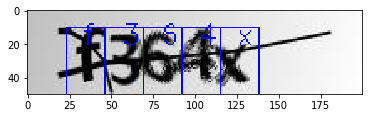

In [23]:
captcha_image_files = list(paths.list_images('samples'))
captcha_image_files = np.random.choice(captcha_image_files, size=(1,), replace=False)

for image_file in captcha_image_files:
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    first = thresh[0:,27:50]
    second = thresh[0:,49:72]
    third = thresh[0:,69:92]
    forth = thresh[0:,92:115]
    fivth = thresh[0:,115:138]

    images = [first, second, third, forth, fivth]

    # Create an output image and a list to hold the predicted letters
    output = image
    predictions = []

    # loop over the letters
    x , y = 23,10
    for letter_bounding_box in images:
        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = letter_bounding_box


        # Turn the single image into a 4d list of images
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)

        # scale the raw pixel intensities to the range [0, 1]
        letter_image = np.array(letter_image, dtype="float") / 255.0
        
        
        # Ask the neural network to make a prediction
        prediction = cnn_model.predict(letter_image)

        # Convert the one-hot-encoded prediction back to a normal letter
        letter = lb.inverse_transform(prediction)[0]
        predictions.append(letter)

        # draw the prediction on the output image
        output =  cv2.rectangle(output, (x , y ), (x + 23, y +  48), (0, 0, 255), 1)
        output = cv2.putText(output, letter, (x +10, y +10 ), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 0, 255), 1)
        x = x+23
    
    # Print the captcha's text
    captcha_text = "".join(predictions)
    print("CAPTCHA text is: {}".format(captcha_text))
    print('Real Captcha text: ',image_file)

    # Show the annotated image
    plt.imshow(output)
